<a href="https://www.kaggle.com/code/medisumeet/air-passengers-time-series-analysis?scriptVersionId=286494030" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-passengers/AirPassengers.csv


In [2]:
# --- 1. Import libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


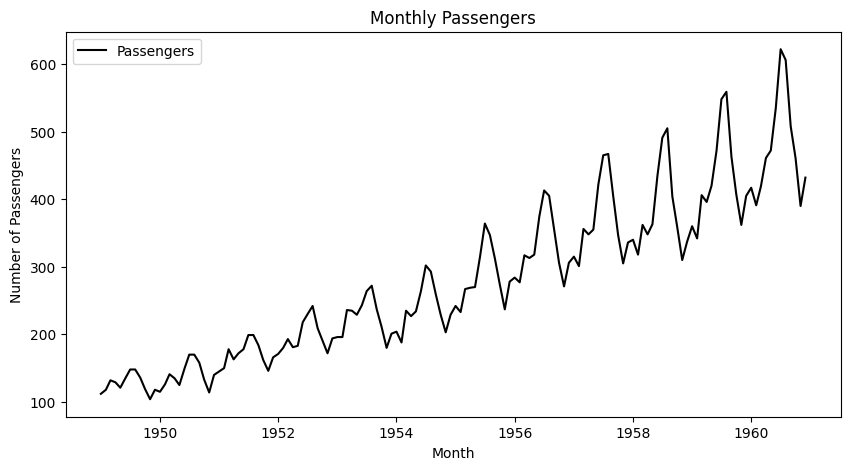

In [3]:
# --- 2. Load dataset ---
df = pd.read_csv("/kaggle/input/air-passengers/AirPassengers.csv")
df['Month'] = pd.to_datetime(df['Month'])

plt.figure(figsize=(10,5))
plt.plot(df['Month'], df['#Passengers'], color='black', label='Passengers')
plt.title("Monthly Passengers")
plt.xlabel("Month")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()


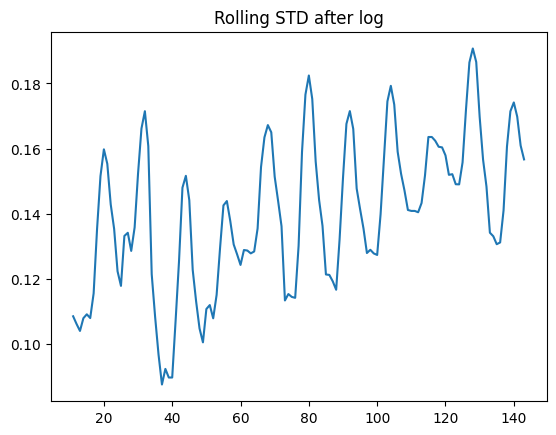

In [4]:
# --- 3. Log transform & Rolling STD ---
log_series = np.log(df['#Passengers'])
log_series.rolling(12).std().plot(title="Rolling STD after log")
plt.show()


Optimal λ: 0.14802254856840585


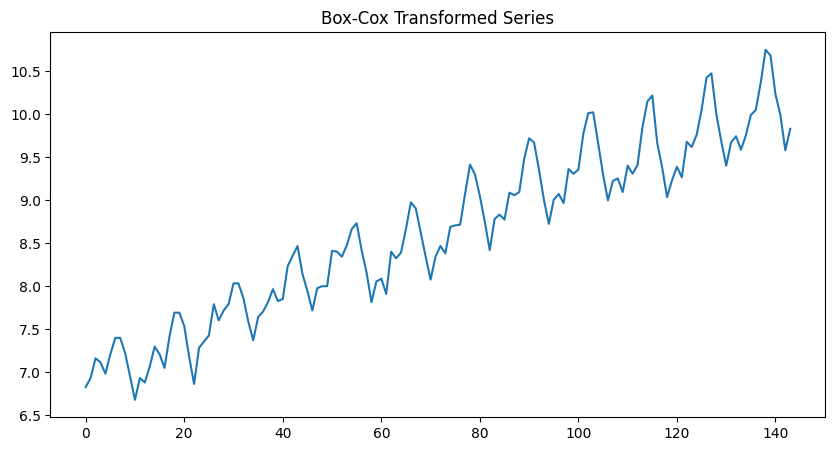

In [5]:
# --- 4. Box-Cox Transformation ---
series_transformed, lambda_opt = boxcox(df['#Passengers'])
print("Optimal λ:", lambda_opt)

plt.figure(figsize=(10,5))
plt.plot(series_transformed)
plt.title("Box-Cox Transformed Series")
plt.show()


In [6]:
# --- 5. Stationarity Check ---
adf_result = adfuller(series_transformed)
print("ADF Statistic:", adf_result[0], "p-value:", adf_result[1])

kpss_stat, p_value, _, _ = kpss(series_transformed, regression='c')
print("KPSS Statistic:", kpss_stat, "p-value:", p_value)


ADF Statistic: -1.3260711769488318 p-value: 0.6171619357969397
KPSS Statistic: 1.672136088216002 p-value: 0.01


/tmp/ipykernel_13/1922336390.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, _, _ = kpss(series_transformed, regression='c')


In [7]:
# --- 6. Differencing ---
diff_series = np.diff(series_transformed)

# Check stationarity after differencing
adf_result_diff = adfuller(diff_series)
print("ADF Statistic (diff):", adf_result_diff[0], "p-value:", adf_result_diff[1])

kpss_stat_diff, p_value_diff, _, _ = kpss(diff_series, regression='c')
print("KPSS Statistic (diff):", kpss_stat_diff, "p-value:", p_value_diff)


ADF Statistic (diff): -2.8717074323147807 p-value: 0.04873834577585664
KPSS Statistic (diff): 0.03219078560222545 p-value: 0.1


/tmp/ipykernel_13/1676127898.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat_diff, p_value_diff, _, _ = kpss(diff_series, regression='c')


<Figure size 1000x500 with 0 Axes>

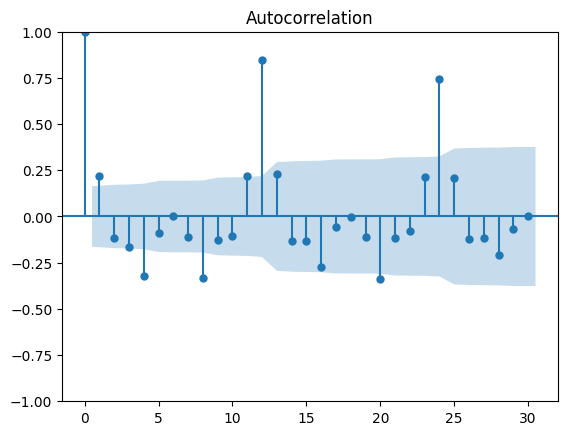

<Figure size 1000x500 with 0 Axes>

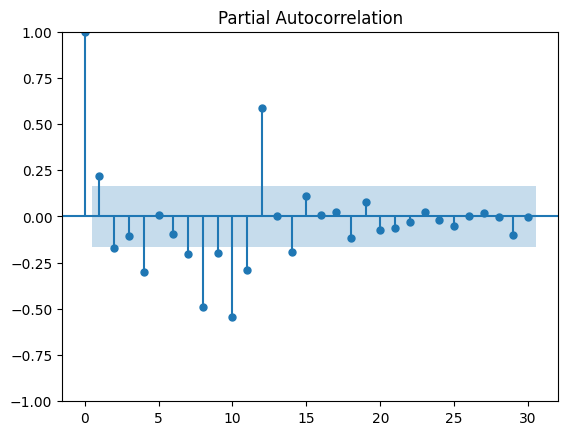

In [8]:
# --- 7. ACF & PACF ---
plt.figure(figsize=(10,5))
plot_acf(diff_series, lags=30)
plt.show()

plt.figure(figsize=(10,5))
plot_pacf(diff_series, lags=30, method='ywm')
plt.show()


In [9]:
# --- 8. Train-Test Split ---
n_test = 24
train = diff_series[:-n_test]
test = diff_series[-n_test:]

# Save last train value for inversion
last_train_value = series_transformed[len(train)]


In [10]:
# --- 9. ARIMA ---
arima_model = ARIMA(train, order=(2,0,1))
arima_fit = arima_model.fit()
forecast_diff_arima = arima_fit.forecast(steps=len(test))
forecast_bc_arima = np.cumsum(forecast_diff_arima) + last_train_value
forecast_arima = inv_boxcox(forecast_bc_arima, lambda_opt)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
# --- 10. SARIMA ---
sarima_model = SARIMAX(train,
                       order=(2,0,1),
                       seasonal_order=(1,0,1,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fit = sarima_model.fit()
forecast_diff_sarima = sarima_fit.forecast(steps=len(test))
forecast_bc_sarima = np.cumsum(forecast_diff_sarima) + last_train_value
forecast_sarima = inv_boxcox(forecast_bc_sarima, lambda_opt)


In [12]:
# --- 11. Evaluation ---
actual = df['#Passengers'][-n_test:].values
rmse_arima = np.sqrt(mean_squared_error(actual, forecast_arima))
rmse_sarima = np.sqrt(mean_squared_error(actual, forecast_sarima))

print("ARIMA RMSE:", rmse_arima)
print("SARIMA RMSE:", rmse_sarima)


ARIMA RMSE: 73.49618029270293
SARIMA RMSE: 32.66033986395145


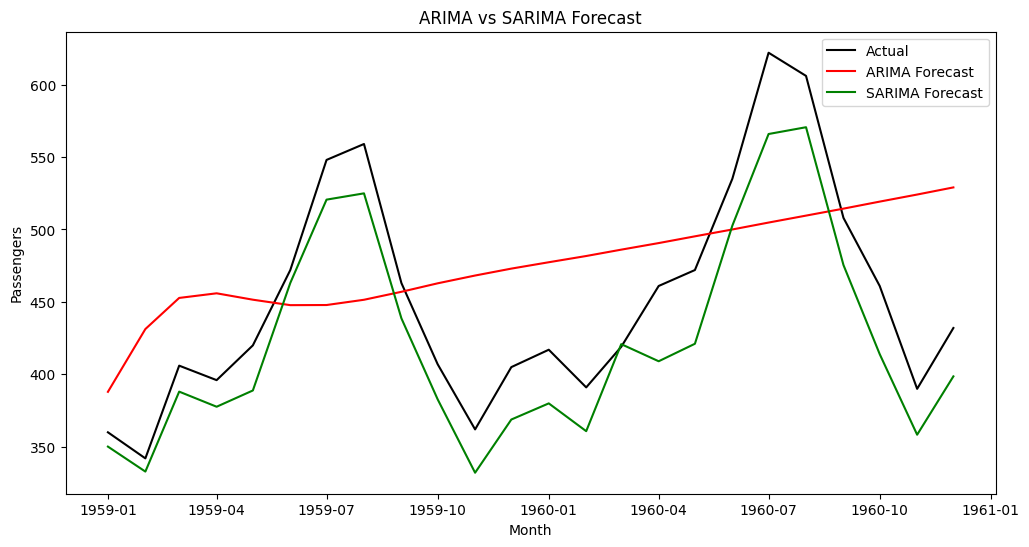

In [13]:
# --- 12. Plot Forecasts ---
plt.figure(figsize=(12,6))
plt.plot(df['Month'][-n_test:], actual, label="Actual", color='black')
plt.plot(df['Month'][-n_test:], forecast_arima, label="ARIMA Forecast", color='red')
plt.plot(df['Month'][-n_test:], forecast_sarima, label="SARIMA Forecast", color='green')
plt.title("ARIMA vs SARIMA Forecast")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.legend()
plt.show()
